In [16]:
from controlled_config import ControlledConfig
from rir_interface import taslp_RIR_Interface
from array_setup import array_setup_10cm_2mic
from locata_utils import cart2sph


import numpy as np

In [17]:
rir_interface = taslp_RIR_Interface()

snr = -5
t60 = 0.2
src_mic_dist = 1.0
noi_mic_dist = 1.0
scenario = "source_moving"
test_config = ControlledConfig(array_setup=array_setup_10cm_2mic, snr=snr, t60=t60,
                                    src_mic_dist = src_mic_dist, noi_mic_dist = noi_mic_dist, 
                                    nb_points=16, same_plane=True)

for idx in range(0, 1):									
    retry_flag = True
    retry_count = 0
    while(retry_flag):
        try:
            static_config_dict = test_config._create_acoustic_scene_config("Static")
            circular_motion_config_dict = test_config._create_acoustic_scene_config("CircularMotion", scenario)
            retry_flag = False
        except AssertionError:
            retry_flag = True
            retry_count += 1	

config_dict = circular_motion_config_dict
room_sz = config_dict['room_sz']
array_pos = config_dict['array_pos']
mic_pos = config_dict['mic_pos']
traj_pts= config_dict['src_traj_pts']
noise_pos= config_dict['noise_pos']
T60= config_dict['t60']
SNR= config_dict['snr']		

### Mapping config pos to keys of rir (Interface)

src_azimuth = np.degrees(cart2sph(traj_pts - array_pos)[:,2])
src_azimuth_keys = np.round(np.where(src_azimuth<0, 360+src_azimuth, src_azimuth)).astype('int32')	

source_rirs, dp_source_rirs = rir_interface.get_rirs(t60=T60, idx_list=list(src_azimuth_keys))

noi_azimuth = np.degrees(cart2sph(noise_pos - array_pos)[:,2])
noi_azimuth_keys = np.round(np.where(noi_azimuth<0, 360+noi_azimuth, noi_azimuth)).astype('int32')	
noise_rirs, _ = rir_interface.get_rirs(t60=T60, idx_list=list(noi_azimuth_keys))


In [18]:
src_azimuth, source_rirs.shape


(array([-46., -41., -36., -31., -26., -21., -16., -11.,  -7.,  -2.,   3.,
          8.,  13.,  18.,  23.,  28.]),
 (16, 2, 4224))

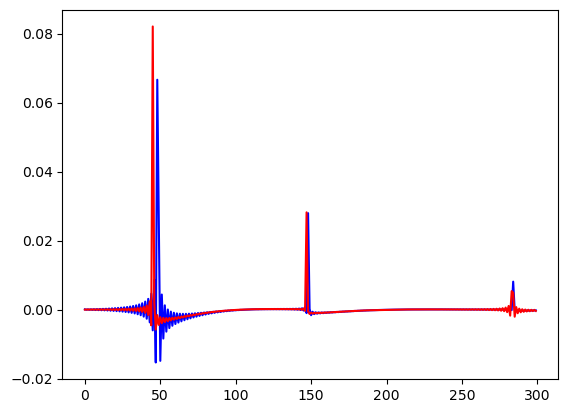

In [19]:
import matplotlib.pyplot as plt

plt.plot(source_rirs[0,0,:300],'b')
plt.plot(source_rirs[0,1,:300],'r')

In [20]:
source_rirs_86, dp_source_rirs_86 = rir_interface.get_rirs(t60=T60, idx_list=[86])

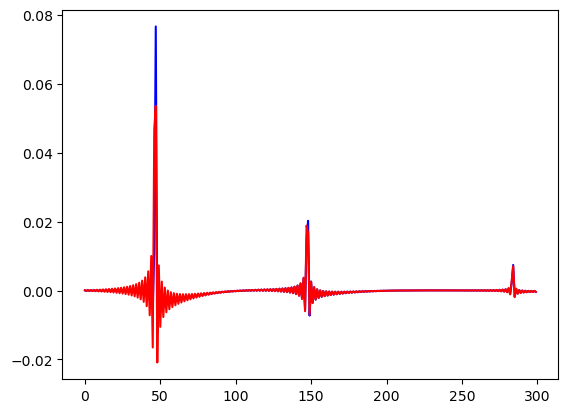

In [21]:
plt.plot(source_rirs_86[0,0,:300],'b')
plt.plot(source_rirs_86[0,1,:300],'r')

In [22]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

t60 = 0.2
files_list = f'/scratch/bbje/battula12/Databases/RIRs/taslp_roomdata_360_resolution_1degree/HABET_SpacedOmni_8x8x3_height1.5_dist1_roomT60_{t60}.mat'
rir = sio.loadmat(files_list)
_h = rir['trainingroom']

In [23]:
h = _h[0,86][0]
h.shape

(4224, 2)

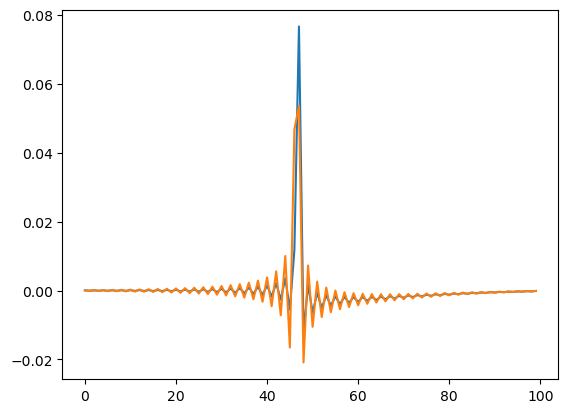

In [24]:
plt.plot(h[:100,0])
plt.plot(h[:100,1])

In [25]:

x = np.array(_h.tolist()).squeeze()
x_1 = np.transpose(x,(0,2,1))
x = np.transpose(x,(0,2,1))
x = x.astype('float32')

In [26]:
x.shape,

((361, 2, 4224),)

In [27]:
np.sum(x[86,:,0]**2), np.sum(x[86,:,1]**2), np.sum(x_1[86,0,:]**2), np.sum(x_1[86,1,:]**2)

(1.0016415e-08, 1.3814065e-08, 0.0076975921717922086, 0.007727222301348132)

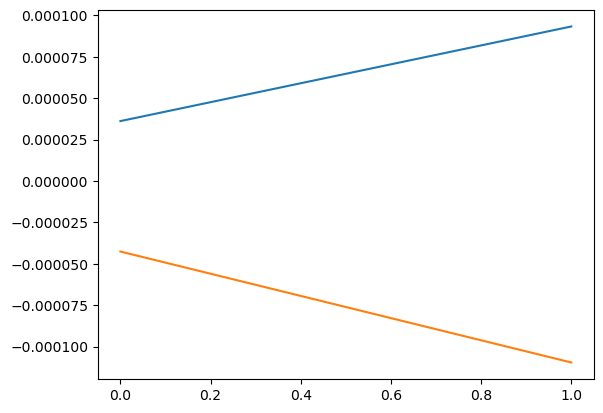

In [28]:
plt.plot(x[86,:,0])
plt.plot(x[86,:,1])

In [29]:
q1 = x[86,:,:]

In [30]:
q1.shape

(2, 4224)

In [47]:
import torch
q1 = torch.from_numpy(q1)
flip_q1 = torch.flip(q1, [1])

In [44]:
flip_q1.shape

torch.Size([2, 4224])

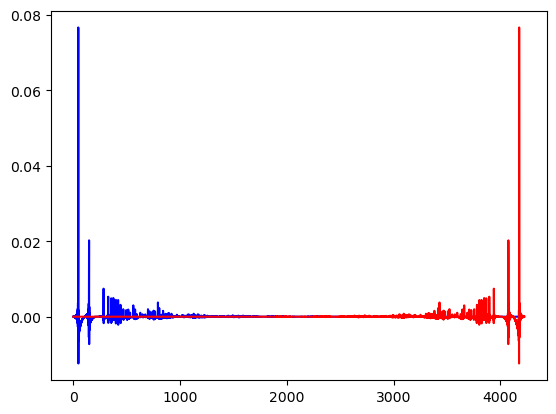

In [33]:
plt.plot(q1[0],'b')
plt.plot(flip_q1[0],'r')

In [110]:
import torchaudio
sig,fs = torchaudio.load('../signals/tgt_0.wav')

In [111]:
sig.shape

torch.Size([2, 64000])

In [51]:
q1 = x[86,:,:]
speech_ = torch.nn.functional.pad(sig[[0],:], (flip_q1.shape[1]-1, flip_q1.shape[1]-1))
augmented = torch.nn.functional.conv1d(speech_.unsqueeze(dim=1), flip_q1.unsqueeze(dim=1))


In [49]:
flip_q1.shape, speech_.shape

(torch.Size([2, 4224]), torch.Size([1, 72446]))

In [52]:
augmented.shape

torch.Size([2, 68223])

In [38]:
augmented_2 = torch.nn.functional.conv1d(sig[[0]], flip_q1[None, ...], padding='same')[0]

RuntimeError: Expected 4-dimensional input for 4-dimensional weight[1, 2, 1, 4224], but got 3-dimensional input of size [1, 1, 64000] instead

In [ ]:
speech_.shape

torch.Size([1, 68223])

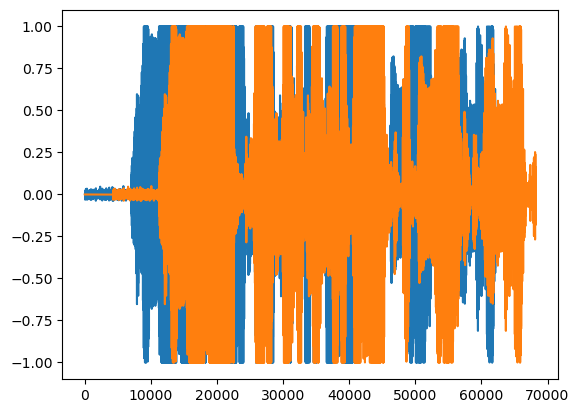

In [ ]:
plt.plot(sig[0])
plt.plot(speech_[0])

In [ ]:
augmented.shape

torch.Size([1, 64000])

In [ ]:
augmented_2.shape

torch.Size([64000])

In [ ]:
augmented[0]==augmented_2

tensor([False, False, False,  ..., False, False, False])

In [ ]:
augmented[0]

tensor([-1.4581e-09,  2.2589e-09, -4.3786e-09,  ..., -3.2324e-03,
         3.5580e-03, -4.3331e-03])

In [ ]:
augmented_2[0]

tensor(0.0003)

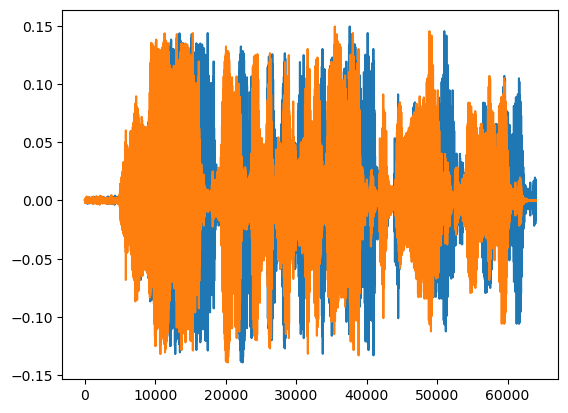

In [ ]:
plt.plot(augmented[0])
plt.plot(augmented_2)

In [54]:
ts = np.arange(16) * 64000 / 16000 / 16

In [59]:
blk_len = int(64000/16)


In [60]:
blk_len

4000

In [63]:
seg_sig = torch.nn.functional.unfold(sig[[0],:].unsqueeze(dim=1).unsqueeze(dim=1), kernel_size=(1, blk_len), padding=(0,0), stride=(1, blk_len))

In [66]:
seg_sig.shape

torch.Size([1, 16, 4000])

In [65]:
seg_sig = torch.permute(seg_sig,[0,2,1])

In [96]:
import torchaudio
mine_sig,fs = torchaudio.load('mine.wav')
gpuRIR_sig,fs = torchaudio.load('gpuRIR.wav')

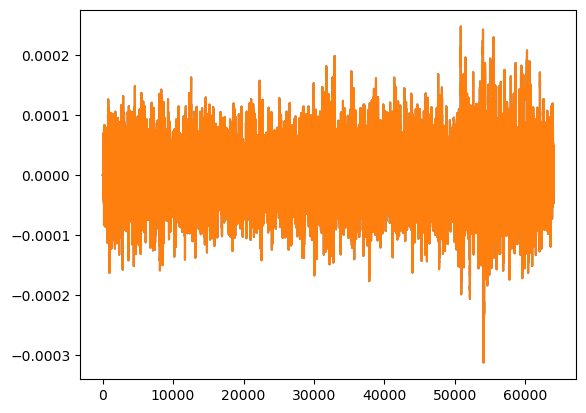

In [97]:
plt.plot(mine_sig[0])
plt.plot(gpuRIR_sig[0])

In [82]:
(gpuRIR_sig==mine_sig)[0].shape

torch.Size([64000])

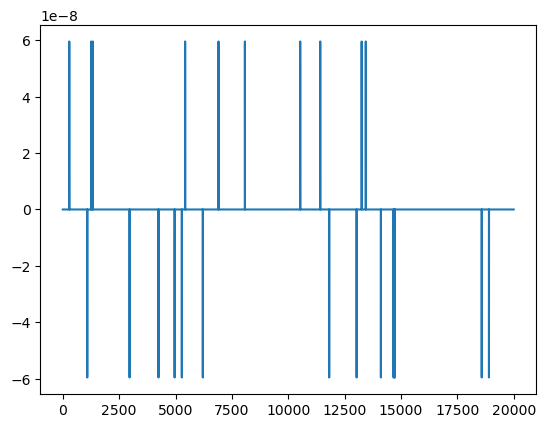

In [109]:
diff = (gpuRIR_sig-mine_sig)
plt.plot(diff[0,:20000])

In [105]:
torch.where(diff[0] !=0)

(tensor([  288,  1086,  1255,  1332,  2963,  4246,  4961,  5281,  5427,  6212,
          6908,  8078, 10531, 11419, 11816, 13033, 13257, 13439, 14110, 14670,
         14708, 14731, 18582, 18903, 23487, 23539, 25006, 25345, 28395, 29574,
         30546, 31163, 31403, 31631, 31828, 32989, 33167, 33711, 37259, 37712,
         39646, 40606, 43816, 44594, 44875, 45800, 45870, 49198, 49621, 49931,
         51660, 52183, 52993, 53448, 53454, 53645, 54123, 54624, 54997, 55244,
         55756, 56180, 56194, 56712, 60687, 60800, 61291, 63735, 63850]),)

In [108]:
diff[0,45800]

tensor(5.9605e-08)

In [74]:
gpuRIR_sig.shape

torch.Size([2, 64000])

In [84]:
diff = (gpuRIR_sig==mine_sig)


In [93]:
(torch.where(diff[0] == False))[0].shape

torch.Size([360])

In [94]:
torch.where(diff[0] == False)

(tensor([  114,   122,   391,   425,   689,   694,  1059,  1074,  1084,  1117,
          1409,  1489,  1512,  1554,  1598,  1749,  1889,  2237,  2320,  2341,
          2566,  3013,  3028,  3075,  3080,  3532,  3917,  4136,  4207,  4322,
          4523,  4593,  4736,  4744,  4930,  5258,  5429,  5719,  5726,  5768,
          5891,  6043,  6091,  6240,  6753,  6861,  7018,  7063,  7102,  7111,
          7797,  8073,  8358,  8420,  9125,  9131,  9625,  9628,  9643,  9704,
          9931, 10307, 10659, 10765, 10878, 10903, 10911, 11079, 11138, 11374,
         11438, 11726, 11775, 11816, 11949, 12122, 12163, 12266, 12320, 12323,
         12390, 12408, 12426, 12508, 12529, 12794, 12808, 12830, 13154, 13263,
         13313, 13505, 13537, 13658, 14102, 14164, 14333, 14467, 14493, 15072,
         15098, 15372, 15963, 16347, 16504, 16889, 16993, 17141, 17177, 17924,
         17927, 18161, 18641, 18860, 19412, 19969, 20380, 20394, 20518, 20818,
         20901, 20907, 20937, 20951, 21438, 21495, 2